In [18]:
import pandas as pd
import numpy as np
import openpyxl as excel

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option('display.max_columns', None)


In [19]:
df = pd.read_excel("Data Sheet Energy.xlsx", skiprows=1)  # skips the first row
print(df.head())


   House_id    Dwelling  Dwelling Grade  Household m2  Size Grade  Bedrooms  \
0         1  Appartment             0.0            36         0.0       1.0   
1         1  Appartment             0.0            36         0.0       1.0   
2         2  Appartment             0.0            95         0.4       2.0   
3         2  Appartment             0.0            95         0.4       2.0   
4         3  Appartment             0.0            80         0.2       2.0   

    Years   Old Heating Source  Area Code  Occupants  Children  Teenagers  \
0   0 - 5  0.00             No      11251          1         0          0   
1   0 - 5  0.00             No      11251          1         0          0   
2  6 - 15  0.33             No      14122          4         1          1   
3  6 - 15  0.33             No      14122          4         1          1   
4  6 - 15  0.33             No      17124          3         1          0   

   Adults  Elders  Ainc  Adec  Agauge  Fulltimers  Parttimers 

In [21]:
# Check missing values
df.isnull().sum()

# Example handling:
# - Fill numerical columns with median
# - Fill categorical columns with mode
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))


In [30]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print(df.columns.tolist())  # check columns are normalized


['house_id', 'dwelling', 'dwelling_grade', 'household_m2', 'size_grade', 'bedrooms', 'years', 'old', 'heating_source', 'area_code', 'occupants', 'children', 'teenagers', 'adults', 'elders', 'ainc', 'adec', 'agauge', 'fulltimers', 'parttimers', 'grads', 'postgrads', 'education_index', 'income', 'recycling', 'energy_class', 'thermostats', 'water_heater', 'smart_plugs', 'awareness', 'start', 'end', 'days', 'kwhs', 'kwh/day', 'kwh/day/m2', 'hdd', 'cdd']


In [37]:
import numpy as np
import re

def income_to_numeric(income_str):
    if pd.isna(income_str):
        return np.nan
    income_str = str(income_str).replace('€', '').replace(' ', '').lower()
    if '-' in income_str:
        parts = income_str.split('-')
        try:
            low = int(parts[0].replace(',', ''))
            high = int(parts[1].replace(',', ''))
            return (low + high) / 2
        except ValueError:
            return np.nan
    if any(word in income_str for word in ['άνωτων', 'άνω', 'above', 'over', 'greaterthan', '>']):
        nums = re.findall(r'\d+', income_str)
        if nums:
            return float(nums[0])
        else:
            return np.nan
    try:
        return int(income_str.replace(',', ''))
    except ValueError:
        return np.nan

df['income'] = df['income'].apply(income_to_numeric)


In [39]:
df_reg = df.dropna(subset=[target] + numeric_features + categorical_features)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features and target
numeric_features = ['household_m2', 'bedrooms', 'occupants', 'children', 'teenagers', 'adults', 'elders', 'income', 'education_index', 'hdd', 'cdd']
categorical_features = ['dwelling', 'dwelling_grade', 'heating_source', 'energy_class', 'recycling', 'thermostats', 'water_heater', 'smart_plugs', 'awareness']
target = 'kwh/day'

# Drop missing rows in needed columns
df_model = df.dropna(subset=[target] + numeric_features + categorical_features)

X = df_model[numeric_features + categorical_features]
y = df_model[target]

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


RMSE: 7.05
R2 Score: 0.27


In [42]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_features = numeric_features + [target]
df_clust = df_model.dropna(subset=cluster_features).copy()
X_clust = df_clust[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

k = 4  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clust['cluster'] = clusters

print(df_clust[['cluster', target]].groupby('cluster').mean())


           kwh/day
cluster           
0         7.239790
1        14.775772
2        16.422544
3        14.607704


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


RMSE: 7.05
MAE: 4.74
R2 Score: 0.27


In [44]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

sil_score = silhouette_score(X_scaled, clusters)
calinski_score = calinski_harabasz_score(X_scaled, clusters)

print(f"Silhouette Score: {sil_score:.2f}")
print(f"Calinski-Harabasz Index: {calinski_score:.2f}")


Silhouette Score: 0.16
Calinski-Harabasz Index: 23.02


In [45]:
def add_custom_features(df):
    # Example: occupancy density = occupants per household size (m²)
    df['occupancy_density'] = df['occupants'] / df['household_m2'].replace(0, 1)

    # Example: age group categorization
    df['age_group'] = pd.cut(df['old'], bins=[0, 18, 40, 65, 120], labels=['child', 'adult', 'middle_aged', 'elderly'])

    # Example: heating dependency (binary flag)
    df['uses_heating'] = df['heating_source'].apply(lambda x: 0 if x == 'none' else 1)

    return df

df = add_custom_features(df)


In [46]:
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge

estimators = [
    ('rf', RandomForestRegressor(random_state=42, n_estimators=100)),
    ('gb', GradientBoostingRegressor(random_state=42, n_estimators=100)),
    ('ridge', Ridge(alpha=1.0))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(random_state=42)
)

# Use the same preprocessing pipeline
model_stack = Pipeline(steps=[('preprocessor', preprocessor),
                              ('stacking', stacking_model)])

model_stack.fit(X_train, y_train)
y_pred_stack = model_stack.predict(X_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacked Model RMSE: {rmse_stack:.2f}")
print(f"Stacked Model R2: {r2_stack:.2f}")


Stacked Model RMSE: 7.78
Stacked Model R2: 0.11


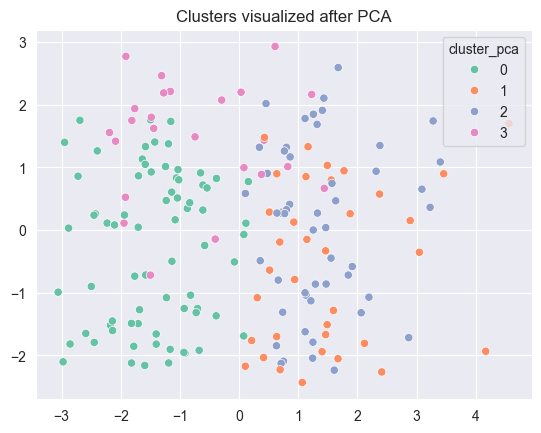

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=4, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

df_clust['cluster_pca'] = clusters_pca

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_clust['cluster_pca'], palette='Set2')
plt.title('Clusters visualized after PCA')
plt.show()


/Users/MAC/Downloads/BigData_Notes/project/capstone_project/venv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


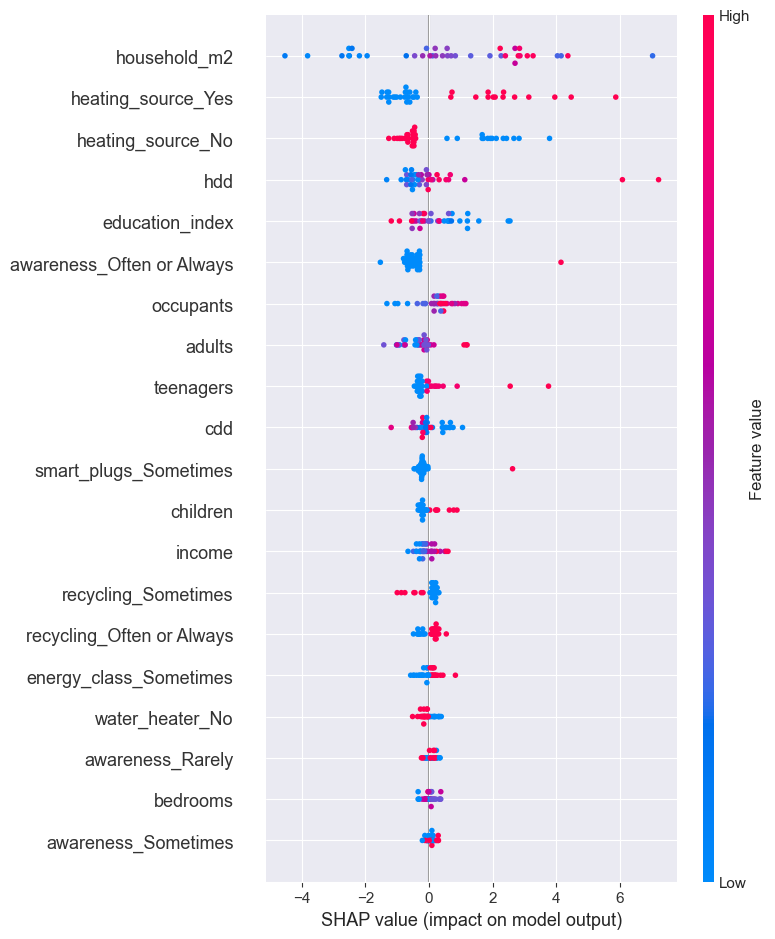

In [48]:
import shap

explainer = shap.TreeExplainer(model.named_steps['regressor'])
shap_values = explainer.shap_values(preprocessor.transform(X_test))

shap.summary_plot(shap_values, features=preprocessor.transform(X_test), feature_names=numeric_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()))
